# Function Calling example with Langchain and Ollama


Model in use: [calebfahlgren/natural-functions](https://ollama.com/calebfahlgren/natural-functions), which is a fine tuned version of Mistral-7B for function calling.

## Tools vs Functions

Your LLM backend considers each "python function" as a tool and based on your input, LLMs capable of "function calling" will pick the most appropriate tool. 
So a python function becomes a tool, and when ready for the LLM they become functions. (!)


Caveats:

    - concrete args structure as pydantic models are required


Lets define some tools as examples:

In [1]:
import json
import re
import time
from typing import Any, Dict, Optional

import ollama
import requests
from langchain.pydantic_v1 import BaseModel, Field
from langchain.tools import tool
from langchain_core.utils.function_calling import convert_to_openai_function
from loguru import logger
from tqdm.auto import tqdm

In [2]:
# a tool to add two numbers

# first the arg model


class AdderModel(BaseModel):
    a: int = Field(..., description="The number")
    b: int = Field(..., description="The number")


# then the function
@tool("add", args_schema=AdderModel)
def add(a: int, b: int) -> int:
    """adds two numbers and returns the sum"""
    logger.info(f"Adding {a} and {b}")
    return a + b

The `AdderModel` class will define the args structure and while parsing the LLM and corresponding modules in Langchain will structure them based on the class.

Let's add more functions / tools. 

In [3]:
from PIL import Image
import io

%matplotlib inline
import matplotlib.pyplot as plt


class RequestModel(BaseModel):
    status_code: int = Field(..., description="The status code of the request")
    url: str = Field("https://http.cat", description="The URL to call")


@tool("get_catcode", args_schema=RequestModel)
def get_catcode(status_code: int, url: str = "https://http.cat") -> int:
    """
    get the status code of a request to a URL
    """
    response = requests.get(url + "/" + str(status_code))
    
    logger.info("Creating image from response")
    content = response.content
    img = Image.open(io.BytesIO(content))
    plt.imshow(img)
    plt.show()


    logger.info(f"Calling {url}")
    return response.status_code

In [4]:
class ItemModel(BaseModel):
    item_name: str = Field(..., description="The name of the item")


items = []


@tool("add_item", args_schema=ItemModel)
def add_item(item_name: str) -> dict:
    """add an item at a specific time to the list of items and return the item"""
    t = time.asctime()
    logger.info(f"Adding {item_name} at {t}")
    item = {"item_name": item_name, "time": t}
    items.append(item)
    logger.info(f"Items: {items}")
    return item

## Parsing function call names from LLM response

In [5]:
# source: https://github.com/cfahlgren1/natural-functions/blob/main/natural-functions-demo.ipynb
def parse_function_call(input_str: str) -> Optional[Dict[str, Any]]:
    """
    Parses a text string to find and extract a function call.
    The function call is expected to be in the format:
    <functioncall> {"name": "<function_name>", "arguments": "<arguments_json_string>"}

    Args:
        input_str (str): The text containing the function call.

    Returns:
        Optional[Dict[str, any]]: A dictionary with 'name' and 'arguments' if a function call is found,
                                  otherwise None.
    """
    # Regex pattern to extract 'name' and 'arguments'
    pattern = r'"name":\s*"([^"]+)",\s*"arguments":\s*\'(.*?)\''

    # Search with regex
    match = re.search(pattern, input_str)
    if match:
        try:
            name = match.group(1)
            arguments_str = match.group(2)

            # Parse the arguments JSON
            arguments = json.loads(arguments_str)

            return {"name": name, "arguments": arguments}
        except json.JSONDecodeError:
            # If JSON parsing fails, return None
            return None
    return None

## Call LLM

In [6]:
def call_llm(messages: list):
    response = ollama.chat(model="calebfahlgren/natural-functions", messages=messages)
    message = response["message"]["content"]  # type: ignore
    return message

## Get function call info

Basically supplies you the name of the function from LLM output to call.

One thing to note here is that, an LLM may fail to assign a function to your input. In that case, the function will retry until a function name has been returned.
(Hacky solution but an LLM isn't your buddy from Adventure Time either.)

In [7]:
def get_function(content_str: str, functions: Any):
    logger.info(f"User input: {content_str}")

    try_count = 0

    SYSTEM_PROMPT = f"""
    You are a helpful assistant with access to these functions -
    {json.dumps(functions, indent=4)}
    """

    messages = [
        {"role": "system", "content": SYSTEM_PROMPT},
        {"role": "user", "content": content_str},
    ]
    message = call_llm(messages)

    function_call = parse_function_call(message)
    while not function_call:
        try_count += 1
        logger.error("Failed to parse function call")
        logger.info(f"Retrying -> Count: {try_count}")

        messages = [
            {"role": "system", "content": SYSTEM_PROMPT},
            {"role": "user", "content": content_str},
        ]

        message = call_llm(messages)

        messages.append({"role": "assistant", "content": message})
        # parse out function call name and args into json
        function_call = parse_function_call(message)

    return function_call

## Define tools

In [8]:
tools = [add_item, get_catcode, add]
# each tool becomes a StructuredObject so regular function properties are not there
# .getname() gives the function / tool name
tool_names = [t.get_name() for t in tools]

# create functions
# basically convert them to a format an LLM will understand
functions = [convert_to_openai_function(t) for t in tools]

## Run on some inputs

In [9]:
contents = [
    "send code 102",
    "add the number 999 with -999",
    "add apple to the list",
]

  0%|          | 0/3 [00:00<?, ?it/s]

2024-04-15 17:21:54.330 | INFO     | __main__:get_function:2 - User input: send code 102


2024-04-15 17:21:55.379 | INFO     | __main__:get_catcode:20 - Creating image from response


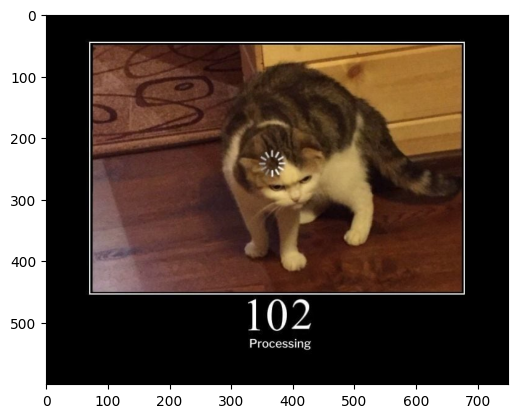

2024-04-15 17:21:55.519 | INFO     | __main__:get_catcode:27 - Calling https://http.cat
2024-04-15 17:21:55.535 | INFO     | __main__:<module>:7 - Result: 200
2024-04-15 17:21:55.548 | INFO     | __main__:get_function:2 - User input: add the number 999 with -999
2024-04-15 17:21:56.390 | INFO     | __main__:add:15 - Adding 999 and -999
2024-04-15 17:21:56.390 | INFO     | __main__:<module>:7 - Result: 0
2024-04-15 17:21:56.392 | INFO     | __main__:get_function:2 - User input: add apple to the list
2024-04-15 17:21:56.961 | ERROR    | __main__:get_function:20 - Failed to parse function call
2024-04-15 17:21:56.961 | INFO     | __main__:get_function:21 - Retrying -> Count: 1
2024-04-15 17:21:57.462 | ERROR    | __main__:get_function:20 - Failed to parse function call
2024-04-15 17:21:57.462 | INFO     | __main__:get_function:21 - Retrying -> Count: 2
2024-04-15 17:21:58.125 | INFO     | __main__:add_item:12 - Adding apple at Mon Apr 15 17:21:58 2024
2024-04-15 17:21:58.126 | INFO     | 

In [10]:
for idx, content_str in tqdm(enumerate(contents), total=len(contents)):
    function_call = get_function(content_str, functions)
    idx = tool_names.index(function_call["name"])
    tool = tools[idx]
    args = function_call.get("arguments")
    result = tool.run(args)
    logger.info(f"Result: {result}")